In [1]:
import timm
import torch
import torch.nn as nn
import torchvision
# import Dataloader
import torch.functional as F
import torch.optim as optim
import math
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn as nn
from tqdm import tqdm
# import Dataloader
# import Updated_DL
from torch.utils.data import random_split
from torch.utils.data import ConcatDataset 
# from sklearn.externals import joblib

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import scipy.io
from PIL import Image
import pandas as pd
from torch.utils.data.dataset import random_split
import scipy
from timm.models.layers import GroupNormAct, ClassifierHead

In [2]:
# model = timm.create_model('resnetv2_50x1_bitm', pretrained=True) 
# model.stages[0]

In [2]:
class CUBDataset(torchvision.datasets.ImageFolder):
    """
    Dataset class for CUB Dataset
    """

    def __init__(self, image_root_path, caption_root_path=None, split="train", *args, **kwargs):
        """
        Args:
            image_root_path:      path to dir containing images and lists folders
            caption_root_path:    path to dir containing captions
            split:          train / test
            *args:
            **kwargs:
        """
        image_info = self.get_file_content(f"{image_root_path}/images.txt")
        self.image_id_to_name = {y[0]: y[1] for y in [x.strip().split(" ") for x in image_info]}
        split_info = self.get_file_content(f"{image_root_path}/train_test_split.txt")
        self.split_info = {self.image_id_to_name[y[0]]: y[1] for y in [x.strip().split(" ") for x in split_info]}
        self.split = "1" if split == "train" else "0"
        self.caption_root_path = caption_root_path

        super(CUBDataset, self).__init__(root=f"{image_root_path}/images", is_valid_file=self.is_valid_file,
                                         *args, **kwargs)

    def is_valid_file(self, x):
        return self.split_info[(x[len(self.root) + 1:])] == self.split

    @staticmethod
    def get_file_content(file_path):
        with open(file_path) as fo:
            content = fo.readlines()
        return content

In [3]:
class DOGDataset(torchvision.datasets.ImageFolder):
    """
    Dataset class for DOG Dataset
    """

    def __init__(self, image_root_path, caption_root_path=None, split="train", *args, **kwargs):
        """
        Args:
            image_root_path:      path to dir containing images and lists folders
            caption_root_path:    path to dir containing captions
            split:          train / test
            *args:
            **kwargs:
        """
        image_info = self.get_file_content(f"{image_root_path}/splits/file_list.mat")
        image_files = [o[0][0] for o in image_info]
        
        split_info = self.get_file_content(f"{image_root_path}/splits/{split}_list.mat")
        split_files = [o[0][0] for o in split_info]
        self.split_info = {}
        if split == 'train' :
            for image in image_files:
                if image in split_files:
                    self.split_info[image] = "1"
                else:
                    self.split_info[image] = "0"
        elif split== 'test' :
            for image in image_files:
                if image in split_files:
                    self.split_info[image] = "0"
                else:
                    self.split_info[image] = "1"
                    
        self.split = "1" if split == "train" else "0"
        self.caption_root_path = caption_root_path

        super(DOGDataset, self).__init__(root=f"{image_root_path}Images", is_valid_file = self.is_valid_file,
                                         *args, **kwargs)
        
        ## modify class index as we are going to concat to first dataset
        self.class_to_idx = {class_: idx+200 for idx, class_ in enumerate(self.class_to_idx)}
        
    def is_valid_file(self, x):
        return self.split_info[(x[len(self.root) + 1:])] == self.split
    
    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = Image.open(os.path.join(path)).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        
        ## modify target class index as we are going to concat to first dataset
        return img, target + 200

    @staticmethod
    def get_file_content(file_path):
        content =  scipy.io.loadmat(file_path)
        return content['file_list']

In [4]:
data_root = "./CUB_200_2011"

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# write data transform here as per the requirement
data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(0.1),
        transforms.RandomRotation(45),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])


train_dataset_cub = CUBDataset(image_root_path=f"{data_root}", transform=data_transform, split="train")
test_dataset_cub = CUBDataset(image_root_path=f"{data_root}", transform=test_transform, split="test")


# load in into the torch dataloader to get variable batch size, shuffle 
train_loader_cub = torch.utils.data.DataLoader(train_dataset_cub, batch_size=32, drop_last=True, shuffle=True)
test_loader_cub = torch.utils.data.DataLoader(test_dataset_cub, batch_size=32, drop_last=False, shuffle=False)

In [5]:
# Set train and test set
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(0.1),
        transforms.RandomRotation(45),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])


data_root = "./dog/dog/"

train_dataset_dog = DOGDataset(image_root_path=f"{data_root}", transform=data_transform, split="train")
test_dataset_dog = DOGDataset(image_root_path=f"{data_root}", transform=test_transform, split="test")
print('Number of train samples:', len(train_dataset_dog))
print('Number of test samples:', len(test_dataset_dog))

# load in into the torch dataloader to get variable batch size, shuffle 
train_loader_dog = torch.utils.data.DataLoader(train_dataset_dog, batch_size=32, drop_last=True, shuffle=True)
test_loader_dog = torch.utils.data.DataLoader(test_dataset_dog, batch_size=32, drop_last=False, shuffle=False)

Number of train samples: 12000
Number of test samples: 8580


In [6]:
concat_dataset_train = ConcatDataset([train_dataset_cub, train_dataset_dog])

t_split = int(len(concat_dataset_train) * 0.9)
v_split = len(concat_dataset_train) - t_split

concat_train_ds, concat_val_ds = random_split(concat_dataset_train, [t_split, v_split])

concat_loader_train = torch.utils.data.DataLoader(
             concat_train_ds,
             batch_size=10, shuffle=True,
             num_workers=1, pin_memory=True
            )

concat_loader_val = torch.utils.data.DataLoader(
             concat_val_ds,
             batch_size=10, shuffle=True,
             num_workers=1, pin_memory=True
            )

concat_dataset_test = ConcatDataset([test_dataset_cub, test_dataset_dog])

concat_loader_test = torch.utils.data.DataLoader(
             concat_dataset_test,
             batch_size=128, shuffle=False,
             num_workers=1, pin_memory=True
            )

In [9]:
class Downsampler(nn.Module):
    def __init__(self, planes, layer_out):
        super(Downsampler, self).__init__()
        # self.conv1 = nn.Conv2d(planes, planes, kernel_size=3, stride=2, padding=0)
        # self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride = 4, padding=0)
        # self.conv3 = nn.Conv2d(planes, planes, kernel_size=2, stride = 2, padding=0)
        self.maxpool1 = nn.MaxPool2d((8,8))
        self.maxpool2 = nn.MaxPool2d((4,4))
        self.maxpool3 = nn.MaxPool2d((2,2))
        self.layer_out = layer_out
        
        
    def forward(self, x):
        if self.layer_out == 1:

            #print('Input shape ', x.shape)
            x = self.maxpool1(x)
            #print('maxpool1 output shape ', x.shape)
            
        elif self.layer_out == 2:
            #print('Input shape ', x.shape)
            x = self.maxpool2(x)
            #print('maxpool2 output shape ', x.shape)
            
        elif self.layer_out == 3:
            #print('Input shape ', x.shape)
            x = self.maxpool3(x)
            #print('maxpool3 output shape ', x.shape)
            
        return x

In [23]:
class newModel(nn.Module):
    def __init__(self, pretrained, num_classes = 320):
        super().__init__()
        self.model = timm.create_model('resnetv2_50x1_bitm', pretrained=pretrained)
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.down1 = Downsampler(64, layer_out=1)
        self.down2 = Downsampler(128, layer_out=2)
        self.down3 = Downsampler(256, layer_out=3)
        
        self.gnorm = GroupNormAct(2048+1024+512+256, num_groups=32)
        self.head = ClassifierHead(2048+1024+512+256, num_classes, pool_type='avg', use_conv=True)
        
    def forward(self, x):
        x = self.model.stem(x)
        x1 = self.model.stages[0](x)
        #print("X1", x1.shape)
        x2 = self.model.stages[1](x1)
        #print("X2", x2.shape)
        x3 = self.model.stages[2](x2)
        #print("X3", x3.shape)
        x = self.model.stages[3](x3)
        #print("X", x.shape)
        
        x1 = self.down1(x1)
        x2 = self.down2(x2)
        x3 = self.down3(x3)
        
        x = torch.cat((x1, x2, x3, x), dim=1)
        
        # x = self.model.norm(x)
        x = self.gnorm(x)
        x = self.head(x)
        return x
        

In [24]:
model = newModel(pretrained=True)

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,236,800 trainable parameters


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else"cpu")
device

device(type='cuda')

In [27]:
model = model.to(device)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4, betas = (0.75, 0.999), weight_decay = 1e-5)
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

Epoch [1/50], Step [10/1620] Train Loss: 5.8485
Epoch [1/50], Step [20/1620] Train Loss: 6.3485
Epoch [1/50], Step [30/1620] Train Loss: 5.9468
Epoch [1/50], Step [40/1620] Train Loss: 6.6477
Epoch [1/50], Step [50/1620] Train Loss: 6.3925
Epoch [1/50], Step [60/1620] Train Loss: 5.4312
Epoch [1/50], Step [70/1620] Train Loss: 6.4054
Epoch [1/50], Step [80/1620] Train Loss: 5.8038
Epoch [1/50], Step [90/1620] Train Loss: 5.5210
Epoch [1/50], Step [100/1620] Train Loss: 5.8640
Epoch [1/50], Step [110/1620] Train Loss: 6.3088
Epoch [1/50], Step [120/1620] Train Loss: 4.7684
Epoch [1/50], Step [130/1620] Train Loss: 4.9665
Epoch [1/50], Step [140/1620] Train Loss: 4.7160
Epoch [1/50], Step [150/1620] Train Loss: 5.8050
Epoch [1/50], Step [160/1620] Train Loss: 5.0710
Epoch [1/50], Step [170/1620] Train Loss: 5.5575
Epoch [1/50], Step [180/1620] Train Loss: 4.8069
Epoch [1/50], Step [190/1620] Train Loss: 5.2513
Epoch [1/50], Step [200/1620] Train Loss: 4.9028
Epoch [1/50], Step [210/1620]

Epoch [2/50], Step [30/1620] Train Loss: 2.5288
Epoch [2/50], Step [40/1620] Train Loss: 2.2408
Epoch [2/50], Step [50/1620] Train Loss: 2.4553
Epoch [2/50], Step [60/1620] Train Loss: 1.9276
Epoch [2/50], Step [70/1620] Train Loss: 2.4688
Epoch [2/50], Step [80/1620] Train Loss: 2.3217
Epoch [2/50], Step [90/1620] Train Loss: 2.5820
Epoch [2/50], Step [100/1620] Train Loss: 1.9636
Epoch [2/50], Step [110/1620] Train Loss: 2.8191
Epoch [2/50], Step [120/1620] Train Loss: 1.8707
Epoch [2/50], Step [130/1620] Train Loss: 2.7313
Epoch [2/50], Step [140/1620] Train Loss: 2.4798
Epoch [2/50], Step [150/1620] Train Loss: 2.4074
Epoch [2/50], Step [160/1620] Train Loss: 1.8872
Epoch [2/50], Step [170/1620] Train Loss: 2.0200
Epoch [2/50], Step [180/1620] Train Loss: 2.5951
Epoch [2/50], Step [190/1620] Train Loss: 1.9694
Epoch [2/50], Step [200/1620] Train Loss: 1.5893
Epoch [2/50], Step [210/1620] Train Loss: 1.8542
Epoch [2/50], Step [220/1620] Train Loss: 2.1447
Epoch [2/50], Step [230/162

Epoch [3/50], Step [50/1620] Train Loss: 2.4874
Epoch [3/50], Step [60/1620] Train Loss: 1.7951
Epoch [3/50], Step [70/1620] Train Loss: 1.8622
Epoch [3/50], Step [80/1620] Train Loss: 0.9801
Epoch [3/50], Step [90/1620] Train Loss: 1.6864
Epoch [3/50], Step [100/1620] Train Loss: 1.9739
Epoch [3/50], Step [110/1620] Train Loss: 1.4740
Epoch [3/50], Step [120/1620] Train Loss: 2.6545
Epoch [3/50], Step [130/1620] Train Loss: 1.7079
Epoch [3/50], Step [140/1620] Train Loss: 1.4859
Epoch [3/50], Step [150/1620] Train Loss: 1.9161
Epoch [3/50], Step [160/1620] Train Loss: 1.3853
Epoch [3/50], Step [170/1620] Train Loss: 1.9073
Epoch [3/50], Step [180/1620] Train Loss: 1.2578
Epoch [3/50], Step [190/1620] Train Loss: 1.6592
Epoch [3/50], Step [200/1620] Train Loss: 1.8242
Epoch [3/50], Step [210/1620] Train Loss: 1.6976
Epoch [3/50], Step [220/1620] Train Loss: 1.2082
Epoch [3/50], Step [230/1620] Train Loss: 1.4782
Epoch [3/50], Step [240/1620] Train Loss: 1.3734
Epoch [3/50], Step [250/1

Epoch [4/50], Step [70/1620] Train Loss: 1.5098
Epoch [4/50], Step [80/1620] Train Loss: 1.3330
Epoch [4/50], Step [90/1620] Train Loss: 1.0774
Epoch [4/50], Step [100/1620] Train Loss: 1.0984
Epoch [4/50], Step [110/1620] Train Loss: 1.5403
Epoch [4/50], Step [120/1620] Train Loss: 1.5970
Epoch [4/50], Step [130/1620] Train Loss: 0.9847
Epoch [4/50], Step [140/1620] Train Loss: 1.8615
Epoch [4/50], Step [150/1620] Train Loss: 1.9881
Epoch [4/50], Step [160/1620] Train Loss: 1.9212
Epoch [4/50], Step [170/1620] Train Loss: 2.0690
Epoch [4/50], Step [180/1620] Train Loss: 1.8968
Epoch [4/50], Step [190/1620] Train Loss: 0.8436
Epoch [4/50], Step [200/1620] Train Loss: 0.9560
Epoch [4/50], Step [210/1620] Train Loss: 1.6101
Epoch [4/50], Step [220/1620] Train Loss: 1.4348
Epoch [4/50], Step [230/1620] Train Loss: 1.2362
Epoch [4/50], Step [240/1620] Train Loss: 1.1215
Epoch [4/50], Step [250/1620] Train Loss: 1.2522
Epoch [4/50], Step [260/1620] Train Loss: 2.1052
Epoch [4/50], Step [270

Epoch [5/50], Step [90/1620] Train Loss: 1.5055
Epoch [5/50], Step [100/1620] Train Loss: 0.7928
Epoch [5/50], Step [110/1620] Train Loss: 1.4482
Epoch [5/50], Step [120/1620] Train Loss: 1.7397
Epoch [5/50], Step [130/1620] Train Loss: 0.8836
Epoch [5/50], Step [140/1620] Train Loss: 0.9823
Epoch [5/50], Step [150/1620] Train Loss: 1.8983
Epoch [5/50], Step [160/1620] Train Loss: 1.6768
Epoch [5/50], Step [170/1620] Train Loss: 1.2913
Epoch [5/50], Step [180/1620] Train Loss: 1.5651
Epoch [5/50], Step [190/1620] Train Loss: 0.8743
Epoch [5/50], Step [200/1620] Train Loss: 1.7780
Epoch [5/50], Step [210/1620] Train Loss: 1.7088
Epoch [5/50], Step [220/1620] Train Loss: 1.8038
Epoch [5/50], Step [230/1620] Train Loss: 1.0569
Epoch [5/50], Step [240/1620] Train Loss: 1.0042
Epoch [5/50], Step [250/1620] Train Loss: 0.8343
Epoch [5/50], Step [260/1620] Train Loss: 0.8574
Epoch [5/50], Step [270/1620] Train Loss: 0.5341
Epoch [5/50], Step [280/1620] Train Loss: 1.6088
Epoch [5/50], Step [2

Epoch [6/50], Step [110/1620] Train Loss: 1.1864
Epoch [6/50], Step [120/1620] Train Loss: 1.9333
Epoch [6/50], Step [130/1620] Train Loss: 1.2059
Epoch [6/50], Step [140/1620] Train Loss: 1.2150
Epoch [6/50], Step [150/1620] Train Loss: 0.6794
Epoch [6/50], Step [160/1620] Train Loss: 1.2547
Epoch [6/50], Step [170/1620] Train Loss: 1.5144
Epoch [6/50], Step [180/1620] Train Loss: 1.3523
Epoch [6/50], Step [190/1620] Train Loss: 0.9191
Epoch [6/50], Step [200/1620] Train Loss: 0.9060
Epoch [6/50], Step [210/1620] Train Loss: 0.6875
Epoch [6/50], Step [220/1620] Train Loss: 1.4515
Epoch [6/50], Step [230/1620] Train Loss: 0.8483
Epoch [6/50], Step [240/1620] Train Loss: 1.3004
Epoch [6/50], Step [250/1620] Train Loss: 1.7045
Epoch [6/50], Step [260/1620] Train Loss: 0.8472
Epoch [6/50], Step [270/1620] Train Loss: 1.6789
Epoch [6/50], Step [280/1620] Train Loss: 1.1680
Epoch [6/50], Step [290/1620] Train Loss: 1.1599
Epoch [6/50], Step [300/1620] Train Loss: 0.7807
Epoch [6/50], Step [

Epoch [7/50], Step [130/1620] Train Loss: 0.6998
Epoch [7/50], Step [140/1620] Train Loss: 1.5552
Epoch [7/50], Step [150/1620] Train Loss: 1.1532
Epoch [7/50], Step [160/1620] Train Loss: 0.8701
Epoch [7/50], Step [170/1620] Train Loss: 1.5173
Epoch [7/50], Step [180/1620] Train Loss: 0.9861
Epoch [7/50], Step [190/1620] Train Loss: 1.5648
Epoch [7/50], Step [200/1620] Train Loss: 0.8591
Epoch [7/50], Step [210/1620] Train Loss: 0.8329
Epoch [7/50], Step [220/1620] Train Loss: 0.6170
Epoch [7/50], Step [230/1620] Train Loss: 0.6986
Epoch [7/50], Step [240/1620] Train Loss: 0.7968
Epoch [7/50], Step [250/1620] Train Loss: 1.3819
Epoch [7/50], Step [260/1620] Train Loss: 1.1136
Epoch [7/50], Step [270/1620] Train Loss: 0.6701
Epoch [7/50], Step [280/1620] Train Loss: 1.0456
Epoch [7/50], Step [290/1620] Train Loss: 1.1286
Epoch [7/50], Step [300/1620] Train Loss: 0.7452
Epoch [7/50], Step [310/1620] Train Loss: 1.6670
Epoch [7/50], Step [320/1620] Train Loss: 0.9590
Epoch [7/50], Step [

Epoch [8/50], Step [150/1620] Train Loss: 0.4931
Epoch [8/50], Step [160/1620] Train Loss: 0.8172
Epoch [8/50], Step [170/1620] Train Loss: 0.8446
Epoch [8/50], Step [180/1620] Train Loss: 0.5443
Epoch [8/50], Step [190/1620] Train Loss: 0.8055
Epoch [8/50], Step [200/1620] Train Loss: 1.0756
Epoch [8/50], Step [210/1620] Train Loss: 0.5767
Epoch [8/50], Step [220/1620] Train Loss: 1.5795
Epoch [8/50], Step [230/1620] Train Loss: 0.4957
Epoch [8/50], Step [240/1620] Train Loss: 0.9744
Epoch [8/50], Step [250/1620] Train Loss: 1.2915
Epoch [8/50], Step [260/1620] Train Loss: 1.8748
Epoch [8/50], Step [270/1620] Train Loss: 1.2311
Epoch [8/50], Step [280/1620] Train Loss: 0.8677
Epoch [8/50], Step [290/1620] Train Loss: 1.0861
Epoch [8/50], Step [300/1620] Train Loss: 0.9182
Epoch [8/50], Step [310/1620] Train Loss: 0.6841
Epoch [8/50], Step [320/1620] Train Loss: 0.4227
Epoch [8/50], Step [330/1620] Train Loss: 0.9400
Epoch [8/50], Step [340/1620] Train Loss: 1.6005
Epoch [8/50], Step [

Epoch [9/50], Step [170/1620] Train Loss: 1.0552
Epoch [9/50], Step [180/1620] Train Loss: 0.8795
Epoch [9/50], Step [190/1620] Train Loss: 0.5813
Epoch [9/50], Step [200/1620] Train Loss: 1.9054
Epoch [9/50], Step [210/1620] Train Loss: 0.7644
Epoch [9/50], Step [220/1620] Train Loss: 2.2325
Epoch [9/50], Step [230/1620] Train Loss: 1.4325
Epoch [9/50], Step [240/1620] Train Loss: 1.3572
Epoch [9/50], Step [250/1620] Train Loss: 0.9880
Epoch [9/50], Step [260/1620] Train Loss: 0.8818
Epoch [9/50], Step [270/1620] Train Loss: 1.2992
Epoch [9/50], Step [280/1620] Train Loss: 0.5867
Epoch [9/50], Step [290/1620] Train Loss: 0.2576
Epoch [9/50], Step [300/1620] Train Loss: 0.3624
Epoch [9/50], Step [310/1620] Train Loss: 1.0726
Epoch [9/50], Step [320/1620] Train Loss: 0.7517
Epoch [9/50], Step [330/1620] Train Loss: 0.7749
Epoch [9/50], Step [340/1620] Train Loss: 1.0903
Epoch [9/50], Step [350/1620] Train Loss: 0.6320
Epoch [9/50], Step [360/1620] Train Loss: 0.8097
Epoch [9/50], Step [

Epoch [10/50], Step [190/1620] Train Loss: 1.1171
Epoch [10/50], Step [200/1620] Train Loss: 0.8088
Epoch [10/50], Step [210/1620] Train Loss: 0.7672
Epoch [10/50], Step [220/1620] Train Loss: 1.2536
Epoch [10/50], Step [230/1620] Train Loss: 1.6043
Epoch [10/50], Step [240/1620] Train Loss: 1.8624
Epoch [10/50], Step [250/1620] Train Loss: 1.5793
Epoch [10/50], Step [260/1620] Train Loss: 0.4737
Epoch [10/50], Step [270/1620] Train Loss: 1.3700
Epoch [10/50], Step [280/1620] Train Loss: 0.6671
Epoch [10/50], Step [290/1620] Train Loss: 1.0232
Epoch [10/50], Step [300/1620] Train Loss: 0.3695
Epoch [10/50], Step [310/1620] Train Loss: 0.8385
Epoch [10/50], Step [320/1620] Train Loss: 0.9823
Epoch [10/50], Step [330/1620] Train Loss: 1.0608
Epoch [10/50], Step [340/1620] Train Loss: 0.6446
Epoch [10/50], Step [350/1620] Train Loss: 0.5538
Epoch [10/50], Step [360/1620] Train Loss: 0.6501
Epoch [10/50], Step [370/1620] Train Loss: 0.7739
Epoch [10/50], Step [380/1620] Train Loss: 0.7182


Epoch [11/50], Step [180/1620] Train Loss: 0.5920
Epoch [11/50], Step [190/1620] Train Loss: 0.6576
Epoch [11/50], Step [200/1620] Train Loss: 1.0257
Epoch [11/50], Step [210/1620] Train Loss: 0.9774
Epoch [11/50], Step [220/1620] Train Loss: 0.6538
Epoch [11/50], Step [230/1620] Train Loss: 0.6325
Epoch [11/50], Step [240/1620] Train Loss: 0.2515
Epoch [11/50], Step [250/1620] Train Loss: 0.5571
Epoch [11/50], Step [260/1620] Train Loss: 1.2161
Epoch [11/50], Step [270/1620] Train Loss: 0.9466
Epoch [11/50], Step [280/1620] Train Loss: 0.5477
Epoch [11/50], Step [290/1620] Train Loss: 0.9941
Epoch [11/50], Step [300/1620] Train Loss: 2.0259
Epoch [11/50], Step [310/1620] Train Loss: 0.5166
Epoch [11/50], Step [320/1620] Train Loss: 1.2897
Epoch [11/50], Step [330/1620] Train Loss: 0.8415
Epoch [11/50], Step [340/1620] Train Loss: 0.8370
Epoch [11/50], Step [350/1620] Train Loss: 1.1353
Epoch [11/50], Step [360/1620] Train Loss: 1.0276
Epoch [11/50], Step [370/1620] Train Loss: 0.9597


Epoch [12/50], Step [170/1620] Train Loss: 1.0873
Epoch [12/50], Step [180/1620] Train Loss: 0.5207
Epoch [12/50], Step [190/1620] Train Loss: 0.2244
Epoch [12/50], Step [200/1620] Train Loss: 0.5869
Epoch [12/50], Step [210/1620] Train Loss: 0.8210
Epoch [12/50], Step [220/1620] Train Loss: 0.4490
Epoch [12/50], Step [230/1620] Train Loss: 0.4742
Epoch [12/50], Step [240/1620] Train Loss: 0.2900
Epoch [12/50], Step [250/1620] Train Loss: 0.9646
Epoch [12/50], Step [260/1620] Train Loss: 0.7860
Epoch [12/50], Step [270/1620] Train Loss: 0.9446
Epoch [12/50], Step [280/1620] Train Loss: 1.3632
Epoch [12/50], Step [290/1620] Train Loss: 0.5712
Epoch [12/50], Step [300/1620] Train Loss: 0.7300
Epoch [12/50], Step [310/1620] Train Loss: 1.4313
Epoch [12/50], Step [320/1620] Train Loss: 0.7396
Epoch [12/50], Step [330/1620] Train Loss: 0.7705
Epoch [12/50], Step [340/1620] Train Loss: 1.1493
Epoch [12/50], Step [350/1620] Train Loss: 0.8708
Epoch [12/50], Step [360/1620] Train Loss: 0.7038


Epoch [13/50], Step [160/1620] Train Loss: 1.3616
Epoch [13/50], Step [170/1620] Train Loss: 1.3657
Epoch [13/50], Step [180/1620] Train Loss: 0.6220
Epoch [13/50], Step [190/1620] Train Loss: 0.4390
Epoch [13/50], Step [200/1620] Train Loss: 1.9671
Epoch [13/50], Step [210/1620] Train Loss: 0.7123
Epoch [13/50], Step [220/1620] Train Loss: 0.4502
Epoch [13/50], Step [230/1620] Train Loss: 0.5467
Epoch [13/50], Step [240/1620] Train Loss: 0.9767
Epoch [13/50], Step [250/1620] Train Loss: 0.3860
Epoch [13/50], Step [260/1620] Train Loss: 0.1037
Epoch [13/50], Step [270/1620] Train Loss: 0.8492
Epoch [13/50], Step [280/1620] Train Loss: 0.4251
Epoch [13/50], Step [290/1620] Train Loss: 1.1948
Epoch [13/50], Step [300/1620] Train Loss: 0.5512
Epoch [13/50], Step [310/1620] Train Loss: 0.6040
Epoch [13/50], Step [320/1620] Train Loss: 0.8640
Epoch [13/50], Step [330/1620] Train Loss: 0.8762
Epoch [13/50], Step [340/1620] Train Loss: 0.4205
Epoch [13/50], Step [350/1620] Train Loss: 1.4233


Epoch [14/50], Step [150/1620] Train Loss: 0.7940
Epoch [14/50], Step [160/1620] Train Loss: 0.5470
Epoch [14/50], Step [170/1620] Train Loss: 0.4672
Epoch [14/50], Step [180/1620] Train Loss: 0.3996
Epoch [14/50], Step [190/1620] Train Loss: 0.3251
Epoch [14/50], Step [200/1620] Train Loss: 0.5108
Epoch [14/50], Step [210/1620] Train Loss: 0.6196
Epoch [14/50], Step [220/1620] Train Loss: 1.9310
Epoch [14/50], Step [230/1620] Train Loss: 0.8022
Epoch [14/50], Step [240/1620] Train Loss: 0.8689
Epoch [14/50], Step [250/1620] Train Loss: 0.2217
Epoch [14/50], Step [260/1620] Train Loss: 1.4687
Epoch [14/50], Step [270/1620] Train Loss: 0.9431
Epoch [14/50], Step [280/1620] Train Loss: 0.4274
Epoch [14/50], Step [290/1620] Train Loss: 0.3142
Epoch [14/50], Step [300/1620] Train Loss: 0.6500
Epoch [14/50], Step [310/1620] Train Loss: 0.3594
Epoch [14/50], Step [320/1620] Train Loss: 0.8608
Epoch [14/50], Step [330/1620] Train Loss: 0.3829
Epoch [14/50], Step [340/1620] Train Loss: 1.2695


Epoch [15/50], Step [140/1620] Train Loss: 0.5246
Epoch [15/50], Step [150/1620] Train Loss: 0.8708
Epoch [15/50], Step [160/1620] Train Loss: 0.8734
Epoch [15/50], Step [170/1620] Train Loss: 0.6827
Epoch [15/50], Step [180/1620] Train Loss: 0.3843
Epoch [15/50], Step [190/1620] Train Loss: 1.5235
Epoch [15/50], Step [200/1620] Train Loss: 1.2135
Epoch [15/50], Step [210/1620] Train Loss: 0.8971
Epoch [15/50], Step [220/1620] Train Loss: 0.9321
Epoch [15/50], Step [230/1620] Train Loss: 0.8245
Epoch [15/50], Step [240/1620] Train Loss: 0.2423
Epoch [15/50], Step [250/1620] Train Loss: 1.3599
Epoch [15/50], Step [260/1620] Train Loss: 1.5309
Epoch [15/50], Step [270/1620] Train Loss: 0.8988
Epoch [15/50], Step [280/1620] Train Loss: 1.6314
Epoch [15/50], Step [290/1620] Train Loss: 0.9565
Epoch [15/50], Step [300/1620] Train Loss: 0.3782
Epoch [15/50], Step [310/1620] Train Loss: 0.4170
Epoch [15/50], Step [320/1620] Train Loss: 1.3303
Epoch [15/50], Step [330/1620] Train Loss: 0.5940


Epoch [16/50], Step [130/1620] Train Loss: 0.8246
Epoch [16/50], Step [140/1620] Train Loss: 0.8869
Epoch [16/50], Step [150/1620] Train Loss: 0.6756
Epoch [16/50], Step [160/1620] Train Loss: 0.8136
Epoch [16/50], Step [170/1620] Train Loss: 0.8670
Epoch [16/50], Step [180/1620] Train Loss: 1.2169
Epoch [16/50], Step [190/1620] Train Loss: 0.8190
Epoch [16/50], Step [200/1620] Train Loss: 1.2496
Epoch [16/50], Step [210/1620] Train Loss: 0.4183
Epoch [16/50], Step [220/1620] Train Loss: 0.9189
Epoch [16/50], Step [230/1620] Train Loss: 0.4174
Epoch [16/50], Step [240/1620] Train Loss: 1.5029
Epoch [16/50], Step [250/1620] Train Loss: 0.4435
Epoch [16/50], Step [260/1620] Train Loss: 0.3410
Epoch [16/50], Step [270/1620] Train Loss: 0.6262
Epoch [16/50], Step [280/1620] Train Loss: 1.3854
Epoch [16/50], Step [290/1620] Train Loss: 0.6068
Epoch [16/50], Step [300/1620] Train Loss: 0.6632
Epoch [16/50], Step [310/1620] Train Loss: 0.4576
Epoch [16/50], Step [320/1620] Train Loss: 0.4751


Epoch [17/50], Step [120/1620] Train Loss: 0.8407
Epoch [17/50], Step [130/1620] Train Loss: 0.9810
Epoch [17/50], Step [140/1620] Train Loss: 0.3351
Epoch [17/50], Step [150/1620] Train Loss: 0.3799
Epoch [17/50], Step [160/1620] Train Loss: 0.5270
Epoch [17/50], Step [170/1620] Train Loss: 0.5132
Epoch [17/50], Step [180/1620] Train Loss: 1.2434
Epoch [17/50], Step [190/1620] Train Loss: 0.5618
Epoch [17/50], Step [200/1620] Train Loss: 1.3381
Epoch [17/50], Step [210/1620] Train Loss: 1.2421
Epoch [17/50], Step [220/1620] Train Loss: 0.2966
Epoch [17/50], Step [230/1620] Train Loss: 0.6235
Epoch [17/50], Step [240/1620] Train Loss: 0.9015
Epoch [17/50], Step [250/1620] Train Loss: 0.8391
Epoch [17/50], Step [260/1620] Train Loss: 0.6081
Epoch [17/50], Step [270/1620] Train Loss: 0.7745
Epoch [17/50], Step [280/1620] Train Loss: 0.5813
Epoch [17/50], Step [290/1620] Train Loss: 0.6952
Epoch [17/50], Step [300/1620] Train Loss: 0.5233
Epoch [17/50], Step [310/1620] Train Loss: 0.6128


Epoch [18/50], Step [110/1620] Train Loss: 0.9414
Epoch [18/50], Step [120/1620] Train Loss: 0.5308
Epoch [18/50], Step [130/1620] Train Loss: 0.5155
Epoch [18/50], Step [140/1620] Train Loss: 0.5985
Epoch [18/50], Step [150/1620] Train Loss: 0.4590
Epoch [18/50], Step [160/1620] Train Loss: 1.2929
Epoch [18/50], Step [170/1620] Train Loss: 0.1027
Epoch [18/50], Step [180/1620] Train Loss: 0.2108
Epoch [18/50], Step [190/1620] Train Loss: 0.2633
Epoch [18/50], Step [200/1620] Train Loss: 0.5187
Epoch [18/50], Step [210/1620] Train Loss: 0.8015
Epoch [18/50], Step [220/1620] Train Loss: 0.9672
Epoch [18/50], Step [230/1620] Train Loss: 0.9182
Epoch [18/50], Step [240/1620] Train Loss: 0.6406
Epoch [18/50], Step [250/1620] Train Loss: 0.6248
Epoch [18/50], Step [260/1620] Train Loss: 0.5067
Epoch [18/50], Step [270/1620] Train Loss: 0.3913
Epoch [18/50], Step [280/1620] Train Loss: 0.7506
Epoch [18/50], Step [290/1620] Train Loss: 0.8291
Epoch [18/50], Step [300/1620] Train Loss: 0.3411


Epoch [19/50], Step [100/1620] Train Loss: 0.7116
Epoch [19/50], Step [110/1620] Train Loss: 0.8936
Epoch [19/50], Step [120/1620] Train Loss: 0.4029
Epoch [19/50], Step [130/1620] Train Loss: 0.4222
Epoch [19/50], Step [140/1620] Train Loss: 0.4446
Epoch [19/50], Step [150/1620] Train Loss: 0.8048
Epoch [19/50], Step [160/1620] Train Loss: 0.7414
Epoch [19/50], Step [170/1620] Train Loss: 0.9084
Epoch [19/50], Step [180/1620] Train Loss: 0.8322
Epoch [19/50], Step [190/1620] Train Loss: 0.2298
Epoch [19/50], Step [200/1620] Train Loss: 0.8273
Epoch [19/50], Step [210/1620] Train Loss: 0.6548
Epoch [19/50], Step [220/1620] Train Loss: 1.0586
Epoch [19/50], Step [230/1620] Train Loss: 0.6068
Epoch [19/50], Step [240/1620] Train Loss: 0.9378
Epoch [19/50], Step [250/1620] Train Loss: 0.6921
Epoch [19/50], Step [260/1620] Train Loss: 0.6757
Epoch [19/50], Step [270/1620] Train Loss: 0.2293
Epoch [19/50], Step [280/1620] Train Loss: 0.5665
Epoch [19/50], Step [290/1620] Train Loss: 0.7021


Epoch [20/50], Step [90/1620] Train Loss: 0.9490
Epoch [20/50], Step [100/1620] Train Loss: 0.5264
Epoch [20/50], Step [110/1620] Train Loss: 0.4890
Epoch [20/50], Step [120/1620] Train Loss: 0.5448
Epoch [20/50], Step [130/1620] Train Loss: 0.6914
Epoch [20/50], Step [140/1620] Train Loss: 0.6950
Epoch [20/50], Step [150/1620] Train Loss: 1.1774
Epoch [20/50], Step [160/1620] Train Loss: 0.8985
Epoch [20/50], Step [170/1620] Train Loss: 0.4088
Epoch [20/50], Step [180/1620] Train Loss: 0.7452
Epoch [20/50], Step [190/1620] Train Loss: 0.7096
Epoch [20/50], Step [200/1620] Train Loss: 0.6368
Epoch [20/50], Step [210/1620] Train Loss: 0.5266
Epoch [20/50], Step [220/1620] Train Loss: 0.4223
Epoch [20/50], Step [230/1620] Train Loss: 0.9400
Epoch [20/50], Step [240/1620] Train Loss: 0.6380
Epoch [20/50], Step [250/1620] Train Loss: 1.1319
Epoch [20/50], Step [260/1620] Train Loss: 1.2440
Epoch [20/50], Step [270/1620] Train Loss: 0.2494
Epoch [20/50], Step [280/1620] Train Loss: 0.9796
E

Epoch [21/50], Step [80/1620] Train Loss: 0.7740
Epoch [21/50], Step [90/1620] Train Loss: 0.2891
Epoch [21/50], Step [100/1620] Train Loss: 1.0791
Epoch [21/50], Step [110/1620] Train Loss: 0.4239
Epoch [21/50], Step [120/1620] Train Loss: 0.8556
Epoch [21/50], Step [130/1620] Train Loss: 1.0847
Epoch [21/50], Step [140/1620] Train Loss: 0.4520
Epoch [21/50], Step [150/1620] Train Loss: 0.6920
Epoch [21/50], Step [160/1620] Train Loss: 0.6231
Epoch [21/50], Step [170/1620] Train Loss: 0.4737
Epoch [21/50], Step [180/1620] Train Loss: 0.1386
Epoch [21/50], Step [190/1620] Train Loss: 0.1745
Epoch [21/50], Step [200/1620] Train Loss: 0.5242
Epoch [21/50], Step [210/1620] Train Loss: 0.4848
Epoch [21/50], Step [220/1620] Train Loss: 0.1441
Epoch [21/50], Step [230/1620] Train Loss: 0.3251
Epoch [21/50], Step [240/1620] Train Loss: 0.5955
Epoch [21/50], Step [250/1620] Train Loss: 0.8772
Epoch [21/50], Step [260/1620] Train Loss: 1.4709
Epoch [21/50], Step [270/1620] Train Loss: 0.6541
Ep

Epoch [22/50], Step [70/1620] Train Loss: 0.5694
Epoch [22/50], Step [80/1620] Train Loss: 0.3547
Epoch [22/50], Step [90/1620] Train Loss: 0.4549
Epoch [22/50], Step [100/1620] Train Loss: 0.9830
Epoch [22/50], Step [110/1620] Train Loss: 0.3225
Epoch [22/50], Step [120/1620] Train Loss: 0.8315
Epoch [22/50], Step [130/1620] Train Loss: 0.0921
Epoch [22/50], Step [140/1620] Train Loss: 0.9187
Epoch [22/50], Step [150/1620] Train Loss: 0.7462
Epoch [22/50], Step [160/1620] Train Loss: 0.3879
Epoch [22/50], Step [170/1620] Train Loss: 0.9020
Epoch [22/50], Step [180/1620] Train Loss: 1.0854
Epoch [22/50], Step [190/1620] Train Loss: 0.9549
Epoch [22/50], Step [200/1620] Train Loss: 0.3673
Epoch [22/50], Step [210/1620] Train Loss: 0.3692
Epoch [22/50], Step [220/1620] Train Loss: 0.8255
Epoch [22/50], Step [230/1620] Train Loss: 0.5587
Epoch [22/50], Step [240/1620] Train Loss: 0.2514
Epoch [22/50], Step [250/1620] Train Loss: 1.4625
Epoch [22/50], Step [260/1620] Train Loss: 0.4677
Epo

Epoch [23/50], Step [60/1620] Train Loss: 0.3661
Epoch [23/50], Step [70/1620] Train Loss: 0.1927
Epoch [23/50], Step [80/1620] Train Loss: 0.8474
Epoch [23/50], Step [90/1620] Train Loss: 1.2327
Epoch [23/50], Step [100/1620] Train Loss: 0.6737
Epoch [23/50], Step [110/1620] Train Loss: 0.4079
Epoch [23/50], Step [120/1620] Train Loss: 0.5201
Epoch [23/50], Step [130/1620] Train Loss: 0.7372
Epoch [23/50], Step [140/1620] Train Loss: 0.9780
Epoch [23/50], Step [150/1620] Train Loss: 0.4746
Epoch [23/50], Step [160/1620] Train Loss: 0.8472
Epoch [23/50], Step [170/1620] Train Loss: 0.6412
Epoch [23/50], Step [180/1620] Train Loss: 0.3694
Epoch [23/50], Step [190/1620] Train Loss: 0.5814
Epoch [23/50], Step [200/1620] Train Loss: 0.4877
Epoch [23/50], Step [210/1620] Train Loss: 0.6073
Epoch [23/50], Step [220/1620] Train Loss: 0.9804
Epoch [23/50], Step [230/1620] Train Loss: 0.5880
Epoch [23/50], Step [240/1620] Train Loss: 0.4853
Epoch [23/50], Step [250/1620] Train Loss: 0.2534
Epoc

Epoch [24/50], Step [50/1620] Train Loss: 0.4483
Epoch [24/50], Step [60/1620] Train Loss: 0.4926
Epoch [24/50], Step [70/1620] Train Loss: 0.8026
Epoch [24/50], Step [80/1620] Train Loss: 0.5090
Epoch [24/50], Step [90/1620] Train Loss: 0.6371
Epoch [24/50], Step [100/1620] Train Loss: 0.6810
Epoch [24/50], Step [110/1620] Train Loss: 0.4028
Epoch [24/50], Step [120/1620] Train Loss: 0.3155
Epoch [24/50], Step [130/1620] Train Loss: 0.2884
Epoch [24/50], Step [140/1620] Train Loss: 0.3972
Epoch [24/50], Step [150/1620] Train Loss: 0.6084
Epoch [24/50], Step [160/1620] Train Loss: 0.5108
Epoch [24/50], Step [170/1620] Train Loss: 0.7790
Epoch [24/50], Step [180/1620] Train Loss: 0.2534
Epoch [24/50], Step [190/1620] Train Loss: 0.5475
Epoch [24/50], Step [200/1620] Train Loss: 0.8495
Epoch [24/50], Step [210/1620] Train Loss: 0.7892
Epoch [24/50], Step [220/1620] Train Loss: 0.8284
Epoch [24/50], Step [230/1620] Train Loss: 0.7845
Epoch [24/50], Step [240/1620] Train Loss: 0.3121
Epoch

Epoch [25/50], Step [40/1620] Train Loss: 1.8104
Epoch [25/50], Step [50/1620] Train Loss: 0.5833
Epoch [25/50], Step [60/1620] Train Loss: 0.4481
Epoch [25/50], Step [70/1620] Train Loss: 0.5138
Epoch [25/50], Step [80/1620] Train Loss: 0.7022
Epoch [25/50], Step [90/1620] Train Loss: 0.6910
Epoch [25/50], Step [100/1620] Train Loss: 0.3754
Epoch [25/50], Step [110/1620] Train Loss: 0.7051
Epoch [25/50], Step [120/1620] Train Loss: 0.3449
Epoch [25/50], Step [130/1620] Train Loss: 1.0058
Epoch [25/50], Step [140/1620] Train Loss: 0.4282
Epoch [25/50], Step [150/1620] Train Loss: 0.3306
Epoch [25/50], Step [160/1620] Train Loss: 0.8541
Epoch [25/50], Step [170/1620] Train Loss: 0.9774
Epoch [25/50], Step [180/1620] Train Loss: 0.2799
Epoch [25/50], Step [190/1620] Train Loss: 0.2610
Epoch [25/50], Step [200/1620] Train Loss: 0.7233
Epoch [25/50], Step [210/1620] Train Loss: 0.6737
Epoch [25/50], Step [220/1620] Train Loss: 0.4812
Epoch [25/50], Step [230/1620] Train Loss: 0.3716
Epoch 

Epoch [26/50], Step [30/1620] Train Loss: 0.2894
Epoch [26/50], Step [40/1620] Train Loss: 0.7944
Epoch [26/50], Step [50/1620] Train Loss: 0.5175
Epoch [26/50], Step [60/1620] Train Loss: 0.7558
Epoch [26/50], Step [70/1620] Train Loss: 0.2930
Epoch [26/50], Step [80/1620] Train Loss: 0.3519
Epoch [26/50], Step [90/1620] Train Loss: 0.3941
Epoch [26/50], Step [100/1620] Train Loss: 0.4252
Epoch [26/50], Step [110/1620] Train Loss: 0.5619
Epoch [26/50], Step [120/1620] Train Loss: 0.3741
Epoch [26/50], Step [130/1620] Train Loss: 1.1378
Epoch [26/50], Step [140/1620] Train Loss: 0.6047
Epoch [26/50], Step [150/1620] Train Loss: 0.3196
Epoch [26/50], Step [160/1620] Train Loss: 0.3186
Epoch [26/50], Step [170/1620] Train Loss: 0.2585
Epoch [26/50], Step [180/1620] Train Loss: 0.2922
Epoch [26/50], Step [190/1620] Train Loss: 0.9341
Epoch [26/50], Step [200/1620] Train Loss: 0.3221
Epoch [26/50], Step [210/1620] Train Loss: 0.6358
Epoch [26/50], Step [220/1620] Train Loss: 0.1194
Epoch [

Epoch [27/50], Step [20/1620] Train Loss: 0.7353
Epoch [27/50], Step [30/1620] Train Loss: 0.6125
Epoch [27/50], Step [40/1620] Train Loss: 0.7092
Epoch [27/50], Step [50/1620] Train Loss: 0.2881
Epoch [27/50], Step [60/1620] Train Loss: 0.4386
Epoch [27/50], Step [70/1620] Train Loss: 1.0111
Epoch [27/50], Step [80/1620] Train Loss: 0.1273
Epoch [27/50], Step [90/1620] Train Loss: 0.4265
Epoch [27/50], Step [100/1620] Train Loss: 1.1701
Epoch [27/50], Step [110/1620] Train Loss: 1.6131
Epoch [27/50], Step [120/1620] Train Loss: 0.6017
Epoch [27/50], Step [130/1620] Train Loss: 0.5833
Epoch [27/50], Step [140/1620] Train Loss: 0.4933
Epoch [27/50], Step [150/1620] Train Loss: 1.0553
Epoch [27/50], Step [160/1620] Train Loss: 0.7710
Epoch [27/50], Step [170/1620] Train Loss: 0.5940
Epoch [27/50], Step [180/1620] Train Loss: 0.2035
Epoch [27/50], Step [190/1620] Train Loss: 0.1896
Epoch [27/50], Step [200/1620] Train Loss: 0.3896
Epoch [27/50], Step [210/1620] Train Loss: 0.2774
Epoch [2

Epoch [28/50], Step [10/1620] Train Loss: 0.8257
Epoch [28/50], Step [20/1620] Train Loss: 0.7473
Epoch [28/50], Step [30/1620] Train Loss: 0.8729
Epoch [28/50], Step [40/1620] Train Loss: 0.8819
Epoch [28/50], Step [50/1620] Train Loss: 0.1741
Epoch [28/50], Step [60/1620] Train Loss: 0.8336
Epoch [28/50], Step [70/1620] Train Loss: 0.1557
Epoch [28/50], Step [80/1620] Train Loss: 0.3348
Epoch [28/50], Step [90/1620] Train Loss: 0.1598
Epoch [28/50], Step [100/1620] Train Loss: 0.4572
Epoch [28/50], Step [110/1620] Train Loss: 1.1344
Epoch [28/50], Step [120/1620] Train Loss: 0.7461
Epoch [28/50], Step [130/1620] Train Loss: 1.1294
Epoch [28/50], Step [140/1620] Train Loss: 0.3415
Epoch [28/50], Step [150/1620] Train Loss: 0.3263
Epoch [28/50], Step [160/1620] Train Loss: 0.8401
Epoch [28/50], Step [170/1620] Train Loss: 0.2468
Epoch [28/50], Step [180/1620] Train Loss: 1.7931
Epoch [28/50], Step [190/1620] Train Loss: 0.3630
Epoch [28/50], Step [200/1620] Train Loss: 0.9309
Epoch [28

Val loss at epoch 28 is 0.0095
Val acc at epoch 28 is 81.7217
Epoch [29/50], Step [10/1620] Train Loss: 1.3607
Epoch [29/50], Step [20/1620] Train Loss: 0.5972
Epoch [29/50], Step [30/1620] Train Loss: 0.1998
Epoch [29/50], Step [40/1620] Train Loss: 0.2518
Epoch [29/50], Step [50/1620] Train Loss: 0.9199
Epoch [29/50], Step [60/1620] Train Loss: 0.9088
Epoch [29/50], Step [70/1620] Train Loss: 0.2949
Epoch [29/50], Step [80/1620] Train Loss: 0.5399
Epoch [29/50], Step [90/1620] Train Loss: 1.0147
Epoch [29/50], Step [100/1620] Train Loss: 0.4205
Epoch [29/50], Step [110/1620] Train Loss: 0.4060
Epoch [29/50], Step [120/1620] Train Loss: 0.5426
Epoch [29/50], Step [130/1620] Train Loss: 0.2902
Epoch [29/50], Step [140/1620] Train Loss: 0.4300
Epoch [29/50], Step [150/1620] Train Loss: 0.4039
Epoch [29/50], Step [160/1620] Train Loss: 0.4932
Epoch [29/50], Step [170/1620] Train Loss: 0.2930
Epoch [29/50], Step [180/1620] Train Loss: 0.9645
Epoch [29/50], Step [190/1620] Train Loss: 0.44

Val loss at epoch 29 is 0.0074
Val acc at epoch 29 is 81.7661
Epoch [30/50], Step [10/1620] Train Loss: 0.3188
Epoch [30/50], Step [20/1620] Train Loss: 1.0612
Epoch [30/50], Step [30/1620] Train Loss: 0.9829
Epoch [30/50], Step [40/1620] Train Loss: 0.4843
Epoch [30/50], Step [50/1620] Train Loss: 1.2403
Epoch [30/50], Step [60/1620] Train Loss: 1.1401
Epoch [30/50], Step [70/1620] Train Loss: 0.3635
Epoch [30/50], Step [80/1620] Train Loss: 0.6620
Epoch [30/50], Step [90/1620] Train Loss: 0.2486
Epoch [30/50], Step [100/1620] Train Loss: 0.8122
Epoch [30/50], Step [110/1620] Train Loss: 0.8257
Epoch [30/50], Step [120/1620] Train Loss: 0.4449
Epoch [30/50], Step [130/1620] Train Loss: 0.7542
Epoch [30/50], Step [140/1620] Train Loss: 0.4577
Epoch [30/50], Step [150/1620] Train Loss: 0.3020
Epoch [30/50], Step [160/1620] Train Loss: 0.7482
Epoch [30/50], Step [170/1620] Train Loss: 0.5777
Epoch [30/50], Step [180/1620] Train Loss: 0.4382
Epoch [30/50], Step [190/1620] Train Loss: 0.53

Val loss at epoch 30 is 0.0015
Val acc at epoch 30 is 81.8717
Epoch [31/50], Step [10/1620] Train Loss: 0.4130
Epoch [31/50], Step [20/1620] Train Loss: 0.5463
Epoch [31/50], Step [30/1620] Train Loss: 0.8577
Epoch [31/50], Step [40/1620] Train Loss: 0.6881
Epoch [31/50], Step [50/1620] Train Loss: 0.7297
Epoch [31/50], Step [60/1620] Train Loss: 0.6173
Epoch [31/50], Step [70/1620] Train Loss: 1.0704
Epoch [31/50], Step [80/1620] Train Loss: 0.6165
Epoch [31/50], Step [90/1620] Train Loss: 0.5988
Epoch [31/50], Step [100/1620] Train Loss: 0.2374
Epoch [31/50], Step [110/1620] Train Loss: 0.3320
Epoch [31/50], Step [120/1620] Train Loss: 0.2802
Epoch [31/50], Step [130/1620] Train Loss: 0.4926
Epoch [31/50], Step [140/1620] Train Loss: 0.5558
Epoch [31/50], Step [150/1620] Train Loss: 0.2777
Epoch [31/50], Step [160/1620] Train Loss: 0.6664
Epoch [31/50], Step [170/1620] Train Loss: 0.5492
Epoch [31/50], Step [180/1620] Train Loss: 0.5952
Epoch [31/50], Step [190/1620] Train Loss: 0.35

Val loss at epoch 31 is 0.0057
Val acc at epoch 31 is 82.2163
Epoch [32/50], Step [10/1620] Train Loss: 1.0235
Epoch [32/50], Step [20/1620] Train Loss: 0.6414
Epoch [32/50], Step [30/1620] Train Loss: 0.6613
Epoch [32/50], Step [40/1620] Train Loss: 0.8258
Epoch [32/50], Step [50/1620] Train Loss: 0.5232
Epoch [32/50], Step [60/1620] Train Loss: 0.6616
Epoch [32/50], Step [70/1620] Train Loss: 0.2973
Epoch [32/50], Step [80/1620] Train Loss: 0.9070
Epoch [32/50], Step [90/1620] Train Loss: 0.4427
Epoch [32/50], Step [100/1620] Train Loss: 0.7966
Epoch [32/50], Step [110/1620] Train Loss: 0.4219
Epoch [32/50], Step [120/1620] Train Loss: 0.3524
Epoch [32/50], Step [130/1620] Train Loss: 0.9221
Epoch [32/50], Step [140/1620] Train Loss: 0.2973
Epoch [32/50], Step [150/1620] Train Loss: 0.7022
Epoch [32/50], Step [160/1620] Train Loss: 0.2527
Epoch [32/50], Step [170/1620] Train Loss: 0.6762
Epoch [32/50], Step [180/1620] Train Loss: 0.5476
Epoch [32/50], Step [190/1620] Train Loss: 0.29

Val loss at epoch 32 is 0.0049
Val acc at epoch 32 is 82.1718
Epoch [33/50], Step [10/1620] Train Loss: 0.2309
Epoch [33/50], Step [20/1620] Train Loss: 0.3422
Epoch [33/50], Step [30/1620] Train Loss: 0.4697
Epoch [33/50], Step [40/1620] Train Loss: 0.7769
Epoch [33/50], Step [50/1620] Train Loss: 0.7338
Epoch [33/50], Step [60/1620] Train Loss: 1.5910
Epoch [33/50], Step [70/1620] Train Loss: 1.0626
Epoch [33/50], Step [80/1620] Train Loss: 0.7073
Epoch [33/50], Step [90/1620] Train Loss: 0.5359
Epoch [33/50], Step [100/1620] Train Loss: 1.1630
Epoch [33/50], Step [110/1620] Train Loss: 0.5456
Epoch [33/50], Step [120/1620] Train Loss: 0.8276
Epoch [33/50], Step [130/1620] Train Loss: 0.5656
Epoch [33/50], Step [140/1620] Train Loss: 0.5402
Epoch [33/50], Step [150/1620] Train Loss: 1.0589
Epoch [33/50], Step [160/1620] Train Loss: 0.8652
Epoch [33/50], Step [170/1620] Train Loss: 0.8771
Epoch [33/50], Step [180/1620] Train Loss: 0.6968
Epoch [33/50], Step [190/1620] Train Loss: 0.35

Val loss at epoch 33 is 0.0097
Val acc at epoch 33 is 82.2608
Epoch [34/50], Step [10/1620] Train Loss: 0.2832
Epoch [34/50], Step [20/1620] Train Loss: 0.7038
Epoch [34/50], Step [30/1620] Train Loss: 0.7715
Epoch [34/50], Step [40/1620] Train Loss: 0.7723
Epoch [34/50], Step [50/1620] Train Loss: 0.8694
Epoch [34/50], Step [60/1620] Train Loss: 0.7141
Epoch [34/50], Step [70/1620] Train Loss: 0.4496
Epoch [34/50], Step [80/1620] Train Loss: 0.8068
Epoch [34/50], Step [90/1620] Train Loss: 0.4430
Epoch [34/50], Step [100/1620] Train Loss: 0.5812
Epoch [34/50], Step [110/1620] Train Loss: 0.3332
Epoch [34/50], Step [120/1620] Train Loss: 1.6955
Epoch [34/50], Step [130/1620] Train Loss: 0.8122
Epoch [34/50], Step [140/1620] Train Loss: 0.8238
Epoch [34/50], Step [150/1620] Train Loss: 0.4143
Epoch [34/50], Step [160/1620] Train Loss: 0.9849
Epoch [34/50], Step [170/1620] Train Loss: 0.6430
Epoch [34/50], Step [180/1620] Train Loss: 0.1944
Epoch [34/50], Step [190/1620] Train Loss: 0.40

Val loss at epoch 34 is 0.0121
Val acc at epoch 34 is 82.3441
Epoch [35/50], Step [10/1620] Train Loss: 0.7435
Epoch [35/50], Step [20/1620] Train Loss: 0.6935
Epoch [35/50], Step [30/1620] Train Loss: 0.4695
Epoch [35/50], Step [40/1620] Train Loss: 0.2548
Epoch [35/50], Step [50/1620] Train Loss: 0.7069
Epoch [35/50], Step [60/1620] Train Loss: 1.2314
Epoch [35/50], Step [70/1620] Train Loss: 0.5520
Epoch [35/50], Step [80/1620] Train Loss: 0.7540
Epoch [35/50], Step [90/1620] Train Loss: 0.7831
Epoch [35/50], Step [100/1620] Train Loss: 0.9352
Epoch [35/50], Step [110/1620] Train Loss: 0.2387
Epoch [35/50], Step [120/1620] Train Loss: 0.2373
Epoch [35/50], Step [130/1620] Train Loss: 0.7830
Epoch [35/50], Step [140/1620] Train Loss: 0.2859
Epoch [35/50], Step [150/1620] Train Loss: 0.6620
Epoch [35/50], Step [160/1620] Train Loss: 0.3628
Epoch [35/50], Step [170/1620] Train Loss: 0.2824
Epoch [35/50], Step [180/1620] Train Loss: 0.2864
Epoch [35/50], Step [190/1620] Train Loss: 0.12

Val loss at epoch 35 is 0.0106
Val acc at epoch 35 is 82.2719
Epoch [36/50], Step [10/1620] Train Loss: 0.3490
Epoch [36/50], Step [20/1620] Train Loss: 0.1329
Epoch [36/50], Step [30/1620] Train Loss: 0.4795
Epoch [36/50], Step [40/1620] Train Loss: 0.7749
Epoch [36/50], Step [50/1620] Train Loss: 0.4020
Epoch [36/50], Step [60/1620] Train Loss: 1.5613
Epoch [36/50], Step [70/1620] Train Loss: 0.1659
Epoch [36/50], Step [80/1620] Train Loss: 0.9342
Epoch [36/50], Step [90/1620] Train Loss: 0.7620
Epoch [36/50], Step [100/1620] Train Loss: 0.4744
Epoch [36/50], Step [110/1620] Train Loss: 1.4698
Epoch [36/50], Step [120/1620] Train Loss: 0.6395
Epoch [36/50], Step [130/1620] Train Loss: 0.4861
Epoch [36/50], Step [140/1620] Train Loss: 0.6985
Epoch [36/50], Step [150/1620] Train Loss: 0.9867
Epoch [36/50], Step [160/1620] Train Loss: 0.2359
Epoch [36/50], Step [170/1620] Train Loss: 0.6720
Epoch [36/50], Step [180/1620] Train Loss: 0.1847
Epoch [36/50], Step [190/1620] Train Loss: 0.41

Val loss at epoch 36 is 0.0059
Val acc at epoch 36 is 82.5553
Epoch [37/50], Step [10/1620] Train Loss: 1.0723
Epoch [37/50], Step [20/1620] Train Loss: 0.5656
Epoch [37/50], Step [30/1620] Train Loss: 1.0753
Epoch [37/50], Step [40/1620] Train Loss: 0.6211
Epoch [37/50], Step [50/1620] Train Loss: 1.4475
Epoch [37/50], Step [60/1620] Train Loss: 0.2138
Epoch [37/50], Step [70/1620] Train Loss: 1.6003
Epoch [37/50], Step [80/1620] Train Loss: 0.3089
Epoch [37/50], Step [90/1620] Train Loss: 0.6421
Epoch [37/50], Step [100/1620] Train Loss: 0.5331
Epoch [37/50], Step [110/1620] Train Loss: 0.5667
Epoch [37/50], Step [120/1620] Train Loss: 1.2083
Epoch [37/50], Step [130/1620] Train Loss: 0.4885
Epoch [37/50], Step [140/1620] Train Loss: 0.1548
Epoch [37/50], Step [150/1620] Train Loss: 0.2313
Epoch [37/50], Step [160/1620] Train Loss: 0.4515
Epoch [37/50], Step [170/1620] Train Loss: 0.2743
Epoch [37/50], Step [180/1620] Train Loss: 0.6675
Epoch [37/50], Step [190/1620] Train Loss: 0.30

Val loss at epoch 37 is 0.0080
Val acc at epoch 37 is 82.7053
Epoch [38/50], Step [10/1620] Train Loss: 0.2900
Epoch [38/50], Step [20/1620] Train Loss: 0.6096
Epoch [38/50], Step [30/1620] Train Loss: 0.4033
Epoch [38/50], Step [40/1620] Train Loss: 0.9631
Epoch [38/50], Step [50/1620] Train Loss: 0.6482
Epoch [38/50], Step [60/1620] Train Loss: 0.6135
Epoch [38/50], Step [70/1620] Train Loss: 0.6542
Epoch [38/50], Step [80/1620] Train Loss: 0.9268
Epoch [38/50], Step [90/1620] Train Loss: 0.4489
Epoch [38/50], Step [100/1620] Train Loss: 0.5279
Epoch [38/50], Step [110/1620] Train Loss: 0.4632
Epoch [38/50], Step [120/1620] Train Loss: 0.7270
Epoch [38/50], Step [130/1620] Train Loss: 0.2139
Epoch [38/50], Step [140/1620] Train Loss: 0.6998
Epoch [38/50], Step [150/1620] Train Loss: 0.6426
Epoch [38/50], Step [160/1620] Train Loss: 0.1892
Epoch [38/50], Step [170/1620] Train Loss: 0.6577
Epoch [38/50], Step [180/1620] Train Loss: 0.7117
Epoch [38/50], Step [190/1620] Train Loss: 0.39

Val loss at epoch 38 is 0.0041
Val acc at epoch 38 is 82.4441
Epoch [39/50], Step [10/1620] Train Loss: 0.7885
Epoch [39/50], Step [20/1620] Train Loss: 0.4680
Epoch [39/50], Step [30/1620] Train Loss: 0.2904
Epoch [39/50], Step [40/1620] Train Loss: 0.2192
Epoch [39/50], Step [50/1620] Train Loss: 0.5957
Epoch [39/50], Step [60/1620] Train Loss: 0.5034
Epoch [39/50], Step [70/1620] Train Loss: 0.5327
Epoch [39/50], Step [80/1620] Train Loss: 0.7940
Epoch [39/50], Step [90/1620] Train Loss: 1.5037
Epoch [39/50], Step [100/1620] Train Loss: 0.7626
Epoch [39/50], Step [110/1620] Train Loss: 0.1820
Epoch [39/50], Step [120/1620] Train Loss: 0.5374
Epoch [39/50], Step [130/1620] Train Loss: 0.6107
Epoch [39/50], Step [140/1620] Train Loss: 0.7917
Epoch [39/50], Step [150/1620] Train Loss: 0.8670
Epoch [39/50], Step [160/1620] Train Loss: 0.9349
Epoch [39/50], Step [170/1620] Train Loss: 0.5672
Epoch [39/50], Step [180/1620] Train Loss: 1.0276
Epoch [39/50], Step [190/1620] Train Loss: 0.83

Val loss at epoch 39 is 0.0053
Val acc at epoch 39 is 82.5386
Epoch [40/50], Step [10/1620] Train Loss: 0.0583
Epoch [40/50], Step [20/1620] Train Loss: 0.2700
Epoch [40/50], Step [30/1620] Train Loss: 0.8720
Epoch [40/50], Step [40/1620] Train Loss: 0.6574
Epoch [40/50], Step [50/1620] Train Loss: 0.5973
Epoch [40/50], Step [60/1620] Train Loss: 0.6790
Epoch [40/50], Step [70/1620] Train Loss: 0.3405
Epoch [40/50], Step [80/1620] Train Loss: 0.4579
Epoch [40/50], Step [90/1620] Train Loss: 0.7781
Epoch [40/50], Step [100/1620] Train Loss: 0.4997
Epoch [40/50], Step [110/1620] Train Loss: 0.5455
Epoch [40/50], Step [120/1620] Train Loss: 0.1798
Epoch [40/50], Step [130/1620] Train Loss: 0.9331
Epoch [40/50], Step [140/1620] Train Loss: 1.0555
Epoch [40/50], Step [150/1620] Train Loss: 0.7391
Epoch [40/50], Step [160/1620] Train Loss: 0.4380
Epoch [40/50], Step [170/1620] Train Loss: 0.3573
Epoch [40/50], Step [180/1620] Train Loss: 0.3928
Epoch [40/50], Step [190/1620] Train Loss: 0.78

Val loss at epoch 40 is 0.0095
Val acc at epoch 40 is 82.5220
Epoch [41/50], Step [10/1620] Train Loss: 0.7474
Epoch [41/50], Step [20/1620] Train Loss: 0.8455
Epoch [41/50], Step [30/1620] Train Loss: 0.7059
Epoch [41/50], Step [40/1620] Train Loss: 0.2647
Epoch [41/50], Step [50/1620] Train Loss: 0.0969
Epoch [41/50], Step [60/1620] Train Loss: 0.4233
Epoch [41/50], Step [70/1620] Train Loss: 0.8014
Epoch [41/50], Step [80/1620] Train Loss: 0.4704
Epoch [41/50], Step [90/1620] Train Loss: 0.3009
Epoch [41/50], Step [100/1620] Train Loss: 0.6136
Epoch [41/50], Step [110/1620] Train Loss: 0.5852
Epoch [41/50], Step [120/1620] Train Loss: 0.8058
Epoch [41/50], Step [130/1620] Train Loss: 1.3290
Epoch [41/50], Step [140/1620] Train Loss: 0.4194
Epoch [41/50], Step [150/1620] Train Loss: 0.6902
Epoch [41/50], Step [160/1620] Train Loss: 0.2921
Epoch [41/50], Step [170/1620] Train Loss: 0.4414
Epoch [41/50], Step [180/1620] Train Loss: 0.2465
Epoch [41/50], Step [190/1620] Train Loss: 0.24

Val loss at epoch 41 is 0.0073
Val acc at epoch 41 is 82.5775
Epoch [42/50], Step [10/1620] Train Loss: 0.3211
Epoch [42/50], Step [20/1620] Train Loss: 0.4485
Epoch [42/50], Step [30/1620] Train Loss: 1.0649
Epoch [42/50], Step [40/1620] Train Loss: 0.3491
Epoch [42/50], Step [50/1620] Train Loss: 0.5275
Epoch [42/50], Step [60/1620] Train Loss: 0.9218
Epoch [42/50], Step [70/1620] Train Loss: 0.8969
Epoch [42/50], Step [80/1620] Train Loss: 0.6106
Epoch [42/50], Step [90/1620] Train Loss: 0.5479
Epoch [42/50], Step [100/1620] Train Loss: 0.5132
Epoch [42/50], Step [110/1620] Train Loss: 0.5241
Epoch [42/50], Step [120/1620] Train Loss: 1.2721
Epoch [42/50], Step [130/1620] Train Loss: 0.4945
Epoch [42/50], Step [140/1620] Train Loss: 0.3409
Epoch [42/50], Step [150/1620] Train Loss: 0.4974
Epoch [42/50], Step [160/1620] Train Loss: 0.8379
Epoch [42/50], Step [170/1620] Train Loss: 0.1758
Epoch [42/50], Step [180/1620] Train Loss: 0.8810
Epoch [42/50], Step [190/1620] Train Loss: 0.66

Val loss at epoch 42 is 0.0080
Val acc at epoch 42 is 82.6331
Epoch [43/50], Step [10/1620] Train Loss: 0.1940
Epoch [43/50], Step [20/1620] Train Loss: 0.4634
Epoch [43/50], Step [30/1620] Train Loss: 0.4147
Epoch [43/50], Step [40/1620] Train Loss: 0.5939
Epoch [43/50], Step [50/1620] Train Loss: 0.8597
Epoch [43/50], Step [60/1620] Train Loss: 0.5115
Epoch [43/50], Step [70/1620] Train Loss: 0.6756
Epoch [43/50], Step [80/1620] Train Loss: 0.6801
Epoch [43/50], Step [90/1620] Train Loss: 0.2157
Epoch [43/50], Step [100/1620] Train Loss: 0.8035
Epoch [43/50], Step [110/1620] Train Loss: 0.3135
Epoch [43/50], Step [120/1620] Train Loss: 1.1669
Epoch [43/50], Step [130/1620] Train Loss: 0.3659
Epoch [43/50], Step [140/1620] Train Loss: 0.4175
Epoch [43/50], Step [150/1620] Train Loss: 0.5562
Epoch [43/50], Step [160/1620] Train Loss: 1.1299
Epoch [43/50], Step [170/1620] Train Loss: 0.5052
Epoch [43/50], Step [180/1620] Train Loss: 0.3284
Epoch [43/50], Step [190/1620] Train Loss: 0.31

Val loss at epoch 43 is 0.0105
Val acc at epoch 43 is 82.4664
Epoch [44/50], Step [10/1620] Train Loss: 0.2268
Epoch [44/50], Step [20/1620] Train Loss: 1.0703
Epoch [44/50], Step [30/1620] Train Loss: 0.5668
Epoch [44/50], Step [40/1620] Train Loss: 0.5811
Epoch [44/50], Step [50/1620] Train Loss: 0.3113
Epoch [44/50], Step [60/1620] Train Loss: 1.0118
Epoch [44/50], Step [70/1620] Train Loss: 0.2497
Epoch [44/50], Step [80/1620] Train Loss: 0.6741
Epoch [44/50], Step [90/1620] Train Loss: 0.6021
Epoch [44/50], Step [100/1620] Train Loss: 0.8270
Epoch [44/50], Step [110/1620] Train Loss: 1.6478
Epoch [44/50], Step [120/1620] Train Loss: 0.6048
Epoch [44/50], Step [130/1620] Train Loss: 0.1810
Epoch [44/50], Step [140/1620] Train Loss: 0.4835
Epoch [44/50], Step [150/1620] Train Loss: 0.5366
Epoch [44/50], Step [160/1620] Train Loss: 0.2778
Epoch [44/50], Step [170/1620] Train Loss: 1.0201
Epoch [44/50], Step [180/1620] Train Loss: 0.5361
Epoch [44/50], Step [190/1620] Train Loss: 0.78

Val loss at epoch 44 is 0.0100
Val acc at epoch 44 is 82.6776
Epoch [45/50], Step [10/1620] Train Loss: 0.3208
Epoch [45/50], Step [20/1620] Train Loss: 0.6436
Epoch [45/50], Step [30/1620] Train Loss: 0.7056
Epoch [45/50], Step [40/1620] Train Loss: 0.5951
Epoch [45/50], Step [50/1620] Train Loss: 0.4179
Epoch [45/50], Step [60/1620] Train Loss: 0.6075
Epoch [45/50], Step [70/1620] Train Loss: 0.6824
Epoch [45/50], Step [80/1620] Train Loss: 0.5770
Epoch [45/50], Step [90/1620] Train Loss: 0.3202
Epoch [45/50], Step [100/1620] Train Loss: 0.6771
Epoch [45/50], Step [110/1620] Train Loss: 1.1180
Epoch [45/50], Step [120/1620] Train Loss: 0.4700
Epoch [45/50], Step [130/1620] Train Loss: 0.5469
Epoch [45/50], Step [140/1620] Train Loss: 0.1269
Epoch [45/50], Step [150/1620] Train Loss: 0.8347
Epoch [45/50], Step [160/1620] Train Loss: 0.9805
Epoch [45/50], Step [170/1620] Train Loss: 0.4453
Epoch [45/50], Step [180/1620] Train Loss: 1.1169
Epoch [45/50], Step [190/1620] Train Loss: 1.11

Val loss at epoch 45 is 0.0081
Val acc at epoch 45 is 82.4775
Epoch [46/50], Step [10/1620] Train Loss: 0.0894
Epoch [46/50], Step [20/1620] Train Loss: 0.5173
Epoch [46/50], Step [30/1620] Train Loss: 0.5809
Epoch [46/50], Step [40/1620] Train Loss: 0.7185
Epoch [46/50], Step [50/1620] Train Loss: 0.9752
Epoch [46/50], Step [60/1620] Train Loss: 0.5685
Epoch [46/50], Step [70/1620] Train Loss: 1.4032
Epoch [46/50], Step [80/1620] Train Loss: 0.4561
Epoch [46/50], Step [90/1620] Train Loss: 0.4188
Epoch [46/50], Step [100/1620] Train Loss: 0.4878
Epoch [46/50], Step [110/1620] Train Loss: 0.6113
Epoch [46/50], Step [120/1620] Train Loss: 0.6783
Epoch [46/50], Step [130/1620] Train Loss: 0.3621
Epoch [46/50], Step [140/1620] Train Loss: 0.7477
Epoch [46/50], Step [150/1620] Train Loss: 0.1664
Epoch [46/50], Step [160/1620] Train Loss: 0.4695
Epoch [46/50], Step [170/1620] Train Loss: 0.2563
Epoch [46/50], Step [180/1620] Train Loss: 0.8853
Epoch [46/50], Step [190/1620] Train Loss: 0.86

Val loss at epoch 46 is 0.0035
Val acc at epoch 46 is 82.4164
Epoch [47/50], Step [10/1620] Train Loss: 0.9052
Epoch [47/50], Step [20/1620] Train Loss: 1.0503
Epoch [47/50], Step [30/1620] Train Loss: 0.5768
Epoch [47/50], Step [40/1620] Train Loss: 0.5551
Epoch [47/50], Step [50/1620] Train Loss: 0.7336
Epoch [47/50], Step [60/1620] Train Loss: 0.2931
Epoch [47/50], Step [70/1620] Train Loss: 0.5900
Epoch [47/50], Step [80/1620] Train Loss: 0.1574
Epoch [47/50], Step [90/1620] Train Loss: 0.8054
Epoch [47/50], Step [100/1620] Train Loss: 0.3010
Epoch [47/50], Step [110/1620] Train Loss: 0.2192
Epoch [47/50], Step [120/1620] Train Loss: 0.6523
Epoch [47/50], Step [130/1620] Train Loss: 0.4976
Epoch [47/50], Step [140/1620] Train Loss: 0.3414
Epoch [47/50], Step [150/1620] Train Loss: 0.3335
Epoch [47/50], Step [160/1620] Train Loss: 0.4789
Epoch [47/50], Step [170/1620] Train Loss: 1.2841
Epoch [47/50], Step [180/1620] Train Loss: 0.6723
Epoch [47/50], Step [190/1620] Train Loss: 0.64

Val loss at epoch 47 is 0.0040
Val acc at epoch 47 is 82.3886
Epoch [48/50], Step [10/1620] Train Loss: 0.5802
Epoch [48/50], Step [20/1620] Train Loss: 0.7206
Epoch [48/50], Step [30/1620] Train Loss: 1.0658
Epoch [48/50], Step [40/1620] Train Loss: 0.5043
Epoch [48/50], Step [50/1620] Train Loss: 0.5207
Epoch [48/50], Step [60/1620] Train Loss: 1.2169
Epoch [48/50], Step [70/1620] Train Loss: 1.0318
Epoch [48/50], Step [80/1620] Train Loss: 1.1099
Epoch [48/50], Step [90/1620] Train Loss: 0.5271
Epoch [48/50], Step [100/1620] Train Loss: 0.6926
Epoch [48/50], Step [110/1620] Train Loss: 1.4076
Epoch [48/50], Step [120/1620] Train Loss: 1.0795
Epoch [48/50], Step [130/1620] Train Loss: 0.3232
Epoch [48/50], Step [140/1620] Train Loss: 0.6135
Epoch [48/50], Step [150/1620] Train Loss: 0.3106
Epoch [48/50], Step [160/1620] Train Loss: 0.5603
Epoch [48/50], Step [170/1620] Train Loss: 0.3556
Epoch [48/50], Step [180/1620] Train Loss: 0.8274
Epoch [48/50], Step [190/1620] Train Loss: 0.20

Val loss at epoch 48 is 0.0057
Val acc at epoch 48 is 82.5998
Epoch [49/50], Step [10/1620] Train Loss: 1.0985
Epoch [49/50], Step [20/1620] Train Loss: 0.4345
Epoch [49/50], Step [30/1620] Train Loss: 0.5527
Epoch [49/50], Step [40/1620] Train Loss: 0.3382
Epoch [49/50], Step [50/1620] Train Loss: 0.6481
Epoch [49/50], Step [60/1620] Train Loss: 0.3228
Epoch [49/50], Step [70/1620] Train Loss: 0.8113
Epoch [49/50], Step [80/1620] Train Loss: 0.3191
Epoch [49/50], Step [90/1620] Train Loss: 0.6778
Epoch [49/50], Step [100/1620] Train Loss: 1.2770
Epoch [49/50], Step [110/1620] Train Loss: 0.4401
Epoch [49/50], Step [120/1620] Train Loss: 0.5784
Epoch [49/50], Step [130/1620] Train Loss: 0.7201
Epoch [49/50], Step [140/1620] Train Loss: 0.4714
Epoch [49/50], Step [150/1620] Train Loss: 0.6042
Epoch [49/50], Step [160/1620] Train Loss: 0.8936
Epoch [49/50], Step [170/1620] Train Loss: 0.6168
Epoch [49/50], Step [180/1620] Train Loss: 0.6925
Epoch [49/50], Step [190/1620] Train Loss: 0.28

Val loss at epoch 49 is 0.0075
Val acc at epoch 49 is 82.5831
Epoch [50/50], Step [10/1620] Train Loss: 0.6413
Epoch [50/50], Step [20/1620] Train Loss: 0.5273
Epoch [50/50], Step [30/1620] Train Loss: 0.3995
Epoch [50/50], Step [40/1620] Train Loss: 0.4686
Epoch [50/50], Step [50/1620] Train Loss: 0.0889
Epoch [50/50], Step [60/1620] Train Loss: 0.2351
Epoch [50/50], Step [70/1620] Train Loss: 0.3015
Epoch [50/50], Step [80/1620] Train Loss: 0.7011
Epoch [50/50], Step [90/1620] Train Loss: 0.1596
Epoch [50/50], Step [100/1620] Train Loss: 0.6065
Epoch [50/50], Step [110/1620] Train Loss: 0.5146
Epoch [50/50], Step [120/1620] Train Loss: 1.1016
Epoch [50/50], Step [130/1620] Train Loss: 0.6267
Epoch [50/50], Step [140/1620] Train Loss: 0.2261
Epoch [50/50], Step [150/1620] Train Loss: 1.1844
Epoch [50/50], Step [160/1620] Train Loss: 0.4227
Epoch [50/50], Step [170/1620] Train Loss: 0.3895
Epoch [50/50], Step [180/1620] Train Loss: 0.6701
Epoch [50/50], Step [190/1620] Train Loss: 0.26

Val loss at epoch 50 is 0.0140
Val acc at epoch 50 is 82.3775


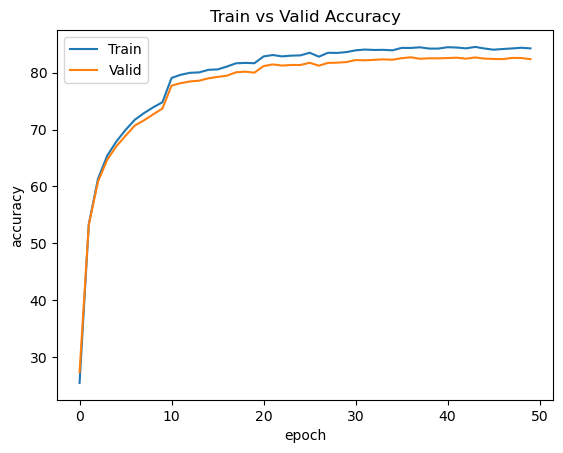

In [29]:
# Train the model
num_epochs = 50
total_step = len(concat_loader_train)
curr_lr = 1e-4
# val_losses = np.array([])
# train_losses = np.array([])
val_losses = []
train_losses = []

val_acc = []
train_acc = []

myfile = open('myfile__resnet50_improved_txt', 'w')
myfile.write('Training results: \n')

for epoch in range(num_epochs):
    running_loss = 0
    correct=0
    total=0
    for i, (images, labels) in enumerate(concat_loader_train):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        # print(images.shape)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimizes
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if (i+1) % 10 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Train Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    train_loss = running_loss / len(concat_loader_train)
    acc = 100.*correct/total

    train_losses.append(train_loss)
    train_acc.append(acc)
    print('Train loss at epoch {} is {:.4f}'.format(epoch+1, train_loss))
    print('Train acc at epoch {} is {:.4f}'.format(epoch+1, acc))
    myfile.write('Train loss at epoch {} is {:.4f}\n'.format(epoch+1, train_loss))
    myfile.write('Train acc at epoch {} is {:.4f}\n'.format(epoch+1, acc))

    model.eval()
    running_loss = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(concat_loader_val):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_loss = loss / len(concat_loader_val) 
    acc = 100.*correct/total
    val_losses.append(val_loss)
    val_acc.append(acc)
    print('Val loss at epoch {} is {:.4f}'.format(epoch+1, val_loss))
    print('Val acc at epoch {} is {:.4f}'.format(epoch+1, acc))
    myfile.write('Val loss at epoch {} is {:.4f}\n'.format(epoch+1, val_loss))
    myfile.write('Val acc at epoch {} is {:.4f}\n'.format(epoch+1, acc))    

    # Decay learning rate
    if (epoch+1) % 10 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)


myfile.close()

plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()


In [36]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for imgs, lbls in concat_loader_test:
        imgs = imgs.to(device)
        lbls = lbls.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs.data, 1)
        total += lbls.size(0)
        correct += (predicted == lbls).sum().item()
        
        
        
    print('Accuracy of the model on the test images : {} %'.format(100 * correct / total))

Accuracy of the model on the test images : 78.14108807569222 %


In [ ]:
x1 = torch.randn([1, 3, 224, 224])

In [ ]:
img = torch.randn([1, 3, 224, 224])
model = newModel(pretrained=True)
output = model(img)
output.shape

In [ ]:
out1 = torch.randn([1, 128, 56, 56])
out2 = torch.randn([1, 256, 28, 28])
out3 = torch.randn([1, 512, 14, 14])
down1 = Downsampler(out1.shape[1], layer_out = 1)
down2 = Downsampler(out2.shape[1], layer_out = 2)
down3 = Downsampler(out3.shape[1], layer_out = 3)

out_down1 = down1(out1)
print(out_down1.shape, '\n')
out_down2 = down2(out2)
print(out_down2.shape, '\n')
out_down3 = down3(out3)
print(out_down3.shape)